In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        enc_sizes = [input_size] + [hidden_size] * (layers - 1) + [bottleneck_size]
        encoder_layers = []
        for r in range(len(enc_sizes)-1):
            encoder_layers.append(nn.Linear(enc_sizes[r], enc_sizes[r+1]))
            if r<len(enc_sizes) - 2:
                encoder_layers.append(nn.ReLU())
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        dec_sizes = enc_sizes[::-1]
        decoder_layers = []
        
        for r in range(len(dec_sizes)-1):
            decoder_layers.append(nn.Linear(dec_sizes[r], dec_sizes[r+1]))
            if r<len(dec_sizes)-2:
                decoder_layers.append(nn.ReLU())
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, code):
        return self.decoder(code)

In [4]:
def train_autoencoder(model, train_loader, lr = 1e-3, epochs = 10):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.train()
    
    hist = {"train_loss":[]}
    
    for e in range(epochs):
        epoch_loss = 0.0
        for data in train_loader:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            
            code, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            
        epoch_loss = epoch_loss/len(train_loader.dataset)
        hist["train_loss"].append(epoch_loss)
        
        print(f"Epoch {e+1}/{epochs}, Loss: {epoch_loss:.6f}")
        
    return model, hist

In [5]:
def data_setup(n_samples = 1000,noise = 0.1, batch_size = 64, random_state =42):
    X, _ = make_moons(n_samples = n_samples, noise = noise, random_state = random_state)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    
    test_loader = DataLoader(dataset, batch_size = len(dataset), shuffle=False)
    
    return loader, test_loader, X

In [6]:
def scatterplot(orig, recon, n, title, legend=True):
    plt.figure(figsize = (10,5))
    plt.scatter(orig[:n,0], orig[:n, 1], label = "Original")
    if recon is not None:
        plt.scatter(recon[:n,0], recon[:n, 1], label = "Reconstructed", marker = "x" )
    if legend:
        plt.legend()
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()
    
def loss_plot (hist, title = "Loss"):
    plt.figure(figsize = (10,5))
    plt.plot(hist["train_loss"], label = "train loss")
    plt.title(title)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.tight_layout()
    plt.show()

In [7]:
def hist_and_gmm(model, data, n_components = 2, n_samples=1000):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = torch.tensor(data.astype(np.float32)).to(device)
        code = model.encode(x).cpu().numpy()
        
    plt.figure(figsize= (10,5))
    if code.shape[1] ==1:
        plt.hist(code[:,0], bins = 30)
        plt.title("Code Bottleneck Distribution")
        plt.xlabel("Code Value")
    else:
        plt.scatter(code[:,0], code[:,1])
        plt.title("Code Scatter")
    plt.tight_layout()
    plt.show()
    
    gmm = GaussianMixture(n_components = n_components, random_state = 42)
    gmm.fit(code)
    sample_code, _ = gmm.sample(n_samples)
    
    with torch.no_grad():
        t = torch.tensor(sample_code.astype(np.float32)).to(device)
        synthetic = model.decode(t).cpu().numpy()
    
    plt.figure(figsize = (10,5))
    plt.scatter(data[:,0], data[:, 1], label = "Original Data")
    plt.scatter(synthetic[:,0], synthetic[:,1], label = "GMM Decoded Synthetic Samples" ,marker='x')
    plt.legend()
    
    plt.title("Original Data vs. GMM-decoded Synthetic Samples")
    plt.tight_layout()
    plt.show()
    
    return code, gmm, synthetic

In [8]:
def evaluate(model, test_loader):
    model.eval()
    criterion = nn.MSELoss(reduction = 'mean')
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            _,outputs = model(inputs)
            loss= criterion(outputs, inputs)
            total += loss.item()*inputs.size(0)
    return total/len(test_loader.dataset)

In [9]:
def hyperparams():
    noise = 0.1
    input_size = 2
    bottleneck_size = 1
    n_samples = 1000
    
    hidden_sizes = [8, 16]
    epochs_list = [10, 50]
    layers_list = [2,3]
    lr_list = [1e-2, 1e-3,]
    
    batch_size = 64
    
    results = []
    total_runs = len(hidden_sizes) * len(layers_list) * len(epochs_list)*len(lr_list)    
    for h in hidden_sizes:
        for l in layers_list:
            for e in epochs_list:
                for lr in lr_list:
                    train_loader, test_loader, data = data_setup(n_samples = n_samples, noise = noise, batch_size = batch_size)
                    model = Autoencoder(input_size, bottleneck_size,h, l).to(device)
                    train_autoencoder(model, train_loader, lr = lr, epochs = e)
                    test_loss = evaluate(model, test_loader)
                    
                    print(f"Hidden Size: {h}, Layers: {l}, Epochs: {e}, LR: {lr}, Test Loss: {test_loss:.4f}")
                    results.append({'hidden':h, 'layers': l, 'epochs':e, 'lr':lr, 'test_loss': test_loss})
    
    df = pd.DataFrame(results)
    
    #Testing loss vs Hidden size
    fixed_layer = 2
    fixed_epoch = 50
    fixed_lr = 1e-3
    
    subset = df[(df.layers == fixed_layer) & (df.epochs == fixed_epoch) & (df.lr == fixed_lr)]    

    plt.figure(figsize = (10,5))
    plt.plot(subset['hidden'], subset['test_loss'], marker = 'x')
    plt.title("Test Set Reconstruction Error vs Hidden Size (Layers = 2, Epochs = 50, LR = 1e-3)")
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    #test loss vs lr
    
    fixed_layer = 2
    fixed_epoch = 50
    fixed_hidden = 16
    
    subset_lr = df[(df.layers == fixed_layer) & (df.epochs == fixed_epoch) & (df.hidden == fixed_hidden)]    

    plt.figure(figsize = (10,5))
    plt.plot(subset_lr['lr'], subset_lr['test_loss'], marker = 'x')
    plt.title("Test MSE vs LR")
    plt.xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    #test loss vs epochs
    
    fixed_layer = 2
    fixed_epoch = 50
    fixed_hidden = 16
    
    subset_epochs = df[(df.layers == fixed_layer) & (df.hidden== fixed_hidden) & (df.lr == fixed_lr)]   

    plt.figure(figsize = (10,5))
    plt.plot(subset_epochs['epochs'], subset_epochs['test_loss'], marker = 'x')
    plt.title("Test MSE vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    best = df.loc[df['test_loss'].idxmin()]
    print(f"Best Hyperparameters Found: {best.to_dict()}")
    
    return best, df

In [10]:
def repeat_training(best_params, repeats = 5):

    n_samples = 1000
    noise = 0.1
    batch_size = 64
    losses = []
    
    for i in range(repeats):
        print(f"Repeat{i+1}/{repeats}")
        train_loader, test_loader, _ = data_setup(n_samples=n_samples, noise = noise, batch_size=batch_size)
        model = Autoencoder(input_size=2,bottleneck_size=1, hidden_size=int(best_params['hidden']), layers = int(best_params['layers'])).to(device)
        train_autoencoder(model, train_loader, lr = float(best_params['lr']), epochs = int(best_params['epochs']))
        test_loss = evaluate(model, test_loader)
        print(f"Test Loss: {test_loss:.6f}")
        losses.append(test_loss)
    
    print(f"Mean test loss over {repeats} runs: {np.mean(losses):.6f}")
    print(f"Std Deviation: {np.std(losses):.6f}")
    
    return losses
    

In [11]:
def test_noisy_data(model, noise=0.2):
    _, test_loader, data_np = data_setup(n_samples=1000, noise=noise, batch_size=64)
    test_loss = evaluate(model, test_loader)
    print(f"Test loss on noise level {noise}: {test_loss:.6f}")

    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(data_np.astype(np.float32)).to(device)
        _, recon = model(x_tensor)
    recon = recon.cpu().numpy()

    scatterplot(data_np, recon, n=200, title=f"Original vs Reconstructed Data (noise={noise})")

def train_noisy_data(best_params):
    noise = 0.2
    n_samples = 1000
    batch_size = 64

    train_loader, test_loader, data_np = data_setup(n_samples=n_samples, noise=noise, batch_size=batch_size)
    model = Autoencoder(2, 1, best_params['hidden'], best_params['layers']).to(device)
    print("Training on noise=0.2 data")
    train_autoencoder(model, train_loader, lr=best_params['lr'], epochs=best_params['epochs'])
    
    test_loss = evaluate(model, test_loader)
    print(f"Test loss on noise=0.2 training data: {test_loss:.6f}")

    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(data_np.astype(np.float32)).to(device)
        _, recon = model(x_tensor)
    recon = recon.cpu().numpy()

    scatterplot(data_np, recon, n=200, title="Original vs Reconstructed Data (noise=0.2)")
    
    return model

Part 1:
Epoch 1/10, Loss: 0.490341
Epoch 2/10, Loss: 0.254436
Epoch 3/10, Loss: 0.154563
Epoch 4/10, Loss: 0.117085
Epoch 5/10, Loss: 0.103307
Epoch 6/10, Loss: 0.096965
Epoch 7/10, Loss: 0.093559
Epoch 8/10, Loss: 0.090612
Epoch 9/10, Loss: 0.087768
Epoch 10/10, Loss: 0.085297
Hidden Size: 8, Layers: 2, Epochs: 10, LR: 0.01, Test Loss: 0.0845
Epoch 1/10, Loss: 0.921899
Epoch 2/10, Loss: 0.836412
Epoch 3/10, Loss: 0.767526
Epoch 4/10, Loss: 0.712056
Epoch 5/10, Loss: 0.669208
Epoch 6/10, Loss: 0.632456
Epoch 7/10, Loss: 0.601609
Epoch 8/10, Loss: 0.575602
Epoch 9/10, Loss: 0.553841
Epoch 10/10, Loss: 0.534205
Hidden Size: 8, Layers: 2, Epochs: 10, LR: 0.001, Test Loss: 0.5242
Epoch 1/50, Loss: 0.684397
Epoch 2/50, Loss: 0.478958
Epoch 3/50, Loss: 0.342587
Epoch 4/50, Loss: 0.212606
Epoch 5/50, Loss: 0.150269
Epoch 6/50, Loss: 0.119365
Epoch 7/50, Loss: 0.104697
Epoch 8/50, Loss: 0.096704
Epoch 9/50, Loss: 0.091076
Epoch 10/50, Loss: 0.088484
Epoch 11/50, Loss: 0.085102
Epoch 12/50, Los

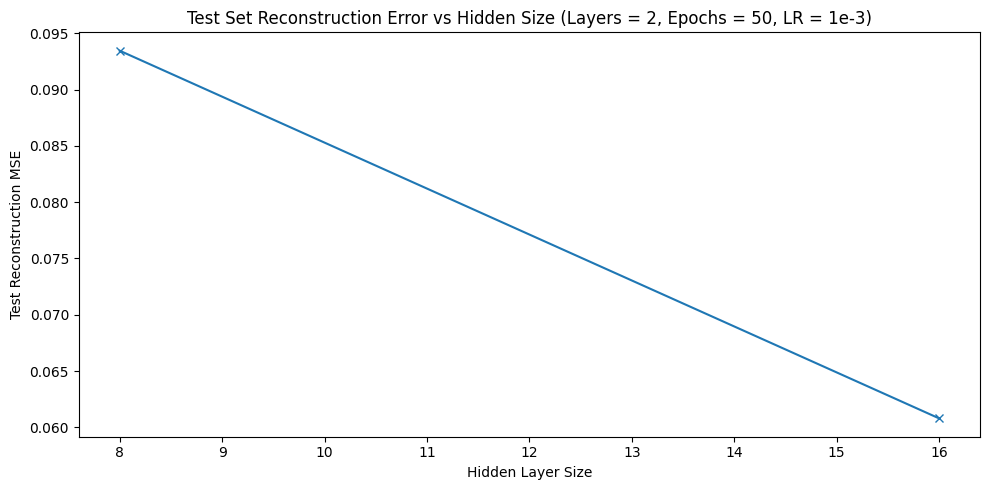

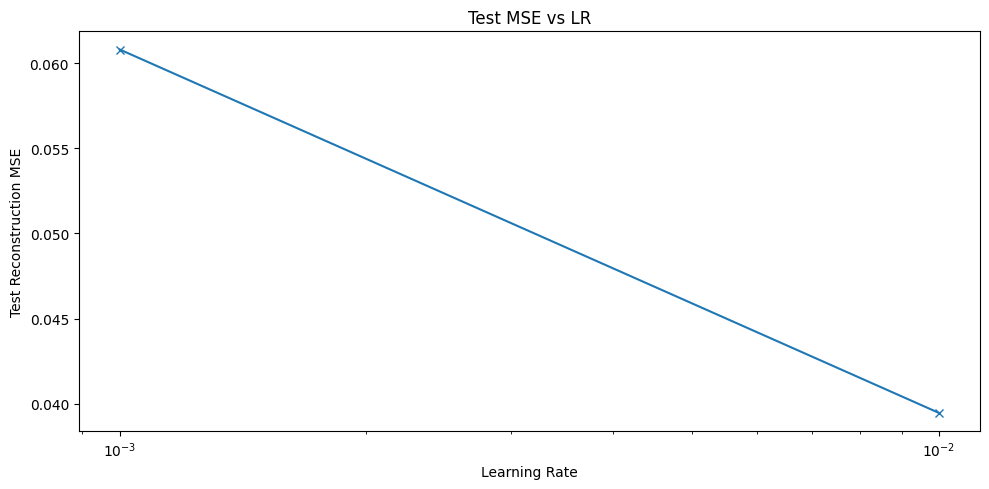

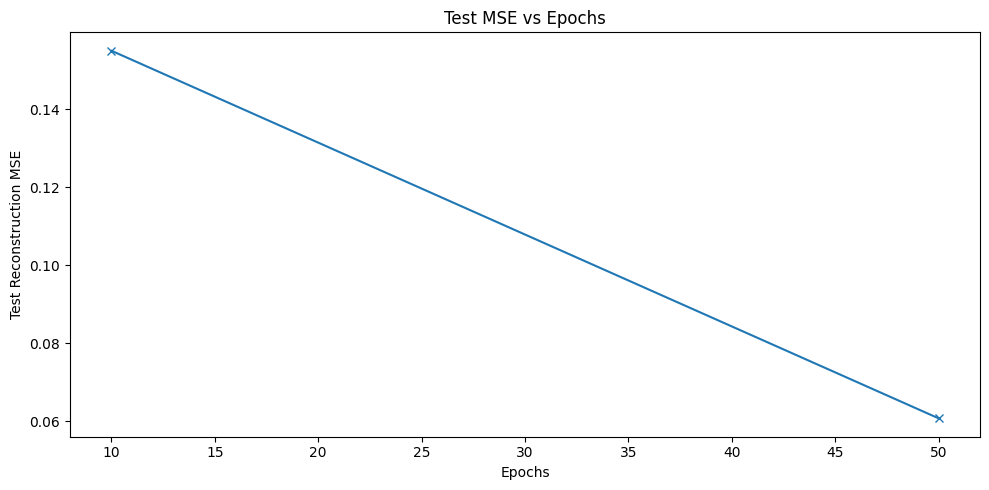

Best Hyperparameters Found: {'hidden': 16.0, 'layers': 3.0, 'epochs': 50.0, 'lr': 0.01, 'test_loss': 0.01405644416809082}


/var/folders/kr/y6vl_94j52vdh_03zdn71zbw0000gp/T/ipykernel_10869/538082896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params['hidden'] = int(best_params['hidden'])
/var/folders/kr/y6vl_94j52vdh_03zdn71zbw0000gp/T/ipykernel_10869/538082896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params['layers'] = int(best_params['layers'])
/var/folders/kr/y6vl_94j52vdh_03zdn71zbw0000gp/T/ipykernel_10869/538082896.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [13]:
print("Part 1:")
best_params, results = hyperparams()

best_params['hidden'] = int(best_params['hidden'])
best_params['layers'] = int(best_params['layers'])
best_params['epochs'] = int(best_params['epochs'])
best_params['lr'] = float(best_params['lr'])


In [14]:
print("\nPart 2: ")
repeat_losses = repeat_training(best_params, repeats=3)
    
print("\nPart 3: ")
train_loader, test_loader, data_np = data_setup(n_samples=1000, noise=0.1, batch_size=64)
best_model = Autoencoder(2, 1, best_params['hidden'], best_params['layers']).to(device)
best_model, hist = train_autoencoder(best_model, train_loader, lr=best_params['lr'], epochs=best_params['epochs'])

loss_plot(hist, title = "Model Training Loss (with best hyperparams)")

code, gmm, synthetic = hist_and_gmm(best_model, data_np, n_components = 2, n_samples = 1000)
    
print("\nPart 4: ")
test_noisy_data(best_model, noise=0.2)
    
print("\nPart 5: ")
trained_noisy_model = train_noisy_data(best_params)


Part 2: 
Repeat1/3
Epoch 1/50, Loss: 0.521690
Epoch 2/50, Loss: 0.210475
Epoch 3/50, Loss: 0.114660
Epoch 4/50, Loss: 0.103948
Epoch 5/50, Loss: 0.097827
Epoch 6/50, Loss: 0.091772
Epoch 7/50, Loss: 0.078949
Epoch 8/50, Loss: 0.076080
Epoch 9/50, Loss: 0.063282
Epoch 10/50, Loss: 0.054349
Epoch 11/50, Loss: 0.048684
Epoch 12/50, Loss: 0.047606
Epoch 13/50, Loss: 0.043629
Epoch 14/50, Loss: 0.041851
Epoch 15/50, Loss: 0.040469
Epoch 16/50, Loss: 0.039548
Epoch 17/50, Loss: 0.039274
Epoch 18/50, Loss: 0.038435
Epoch 19/50, Loss: 0.038088
Epoch 20/50, Loss: 0.038074
Epoch 21/50, Loss: 0.036763
Epoch 22/50, Loss: 0.037331
Epoch 23/50, Loss: 0.037393
Epoch 24/50, Loss: 0.036564
Epoch 25/50, Loss: 0.035254
Epoch 26/50, Loss: 0.034578
Epoch 27/50, Loss: 0.034556
Epoch 28/50, Loss: 0.033880
Epoch 29/50, Loss: 0.032353
Epoch 30/50, Loss: 0.032630
Epoch 31/50, Loss: 0.031015
Epoch 32/50, Loss: 0.029682
Epoch 33/50, Loss: 0.029538
Epoch 34/50, Loss: 0.029062
Epoch 35/50, Loss: 0.028265
Epoch 36/

TypeError: can't multiply sequence by non-int of type 'numpy.float64'